# Example: Molecule dataset

Here we show a real-world example where we download a molecule dataset where the graphs include energy based measures such as band gap or physical measures such as shear and bulk moduli.  

In [10]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import signal
import scipy as sc

import urllib.request
import os
from pathlib import Path


## Download the dataset

NOTE: If the below cell does not work then please download directly from https://figshare.com/articles/Graphs_of_materials_project/7451351 and place into a folder of your choosing.

In [11]:
# load molecules from https://figshare.com/articles/Graphs_of_materials_project/7451351

folder = "./datasets/molecules"
if not Path(folder).exists():
    os.mkdir(folder)  
    
urllib.request.urlretrieve("https://ndownloader.figshare.com/files/15087992", "./datasets/molecules/molecules.json")

## Load the data into python

In [12]:
with open('./datasets/molecules/mp.2018.6.1.json') as json_file:
    data = json.load(json_file)    

Since the dataset is quite large and this is an example, the next cell filters out those molecules that don't have a bulk and shear moduli label.

In [13]:
# only look at molecules with bulk and shear moduli available       
mols = []
for mol in data:
    if 'G' in list(mol.keys()):
        mols.append(mol)

# Graph construction from raw data

In [14]:
#  construct graph from bond energies
data = []    

keys = set(x for l in mols for x in l)

G = np.zeros(len(mols))
K = np.zeros(len(mols))
band_gap = np.zeros(len(mols))
formation_energy = np.zeros(len(mols))
G[:] = np.nan
K[:] = np.nan
band_gap[:] = np.nan
formation_energy[:] = np.nan

labels = []
graphs = []
node_features = []

for i,mol in enumerate(mols):
    graph = mol['graph']    
    edges = pd.DataFrame(columns=['source','target','weight'])
    edges['source'] = graph['index1']
    edges['target'] = graph['index2']
    edges['weight'] = graph['bond']
    edges = edges.groupby(['source','target']).sum()
    edges.reset_index(level=1, inplace=True)
    edges.reset_index(level=0, inplace=True)
    g = nx.from_pandas_edgelist(edges, edge_attr=True)
    
   
    # get node features (N x f)
    node_feats = np.asarray(graph['atom'])
    node_feat_matrix = np.zeros((node_feats.size, 100))
    node_feat_matrix[np.arange(node_feats.size),node_feats] = 1

    
    # append to graphs list
    graphs.append(g)
    labels.append(mol['band_gap'])
    node_features.append(node_feat_matrix)

    #G[i] = mol['G']
    #K[i] = mol['K']
    #band_gap[i] = mol['band_gap']
    #formation_energy[i] = mol['formation_energy_per_atom']

## Load into graph object for hcga

In [16]:
# converting this data into the format required for hcga

from hcga.graph import Graph, GraphCollection

# create graph collection object
g_c = GraphCollection()

# add graphs, node features and labels to the object
g_c.add_graph_list(graphs,node_features,labels)

In [17]:
# perform some sanity checks

print('There are {} graphs'.format(len(g_c.graphs)))
print('There are {} features per node'.format(g_c.get_n_node_features()))


There are 5830 graphs
There are 100 features per node


In [20]:
# we can save this if we want to and run everything from the command line
from hcga.io import save_dataset
save_dataset(g_c, 'molecules', folder='./datasets/molecules/')

# Extracting features


In [22]:
#import hcga object
from hcga.hcga import Hcga

# define an object
h = Hcga()

# load previously saved dataset
h.load_data('./datasets/molecules/molecules.pkl')

In [ ]:
# extracting all features here
h.extract(mode='fast',n_workers=4,timeout=5)

# saving all features into a pickle
h.save_features('./results/molecules/all_features.pkl')


INFO:hcga.extraction:Extracting features from 5475 graphs (we disabled 355 graphs).
INFO:hcga.extraction:Computing features for 5475 graphs:
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:

## Analysis 

Here we perform a regression of the extracted features against bandgap (this label can be changed).

In [21]:
# load the saved features

h.load_features('./results/molecules/all_features.pkl')

INFO:hcga.analysis:2727 total features
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:hcga.utils:0 graphs were removed for more than 0.3 fraction of bad features
INFO:hcga.analysis:1652 valid features
INFO:hcga.analysis:1652 with interpretability 1
INFO:hcga.analysis:... Using Xgboost regressor ...
INFO:hcga.analysis:Using kfold
INFO:hcga.analysis:Mean Absolute Error: --- 0.491 ---
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:hcga.analysis:Mean Absolute Error: --- 0.458 ---
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:hcga.analysis:Mean Absolute Error: --- 0.49 ---
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:hcga.analysis:Mean Absolute Error: --- 0.436 ---
Setting feature_perturbation = "tree_path_dependent" be

Sample Expanded Feature Summary for Class 0


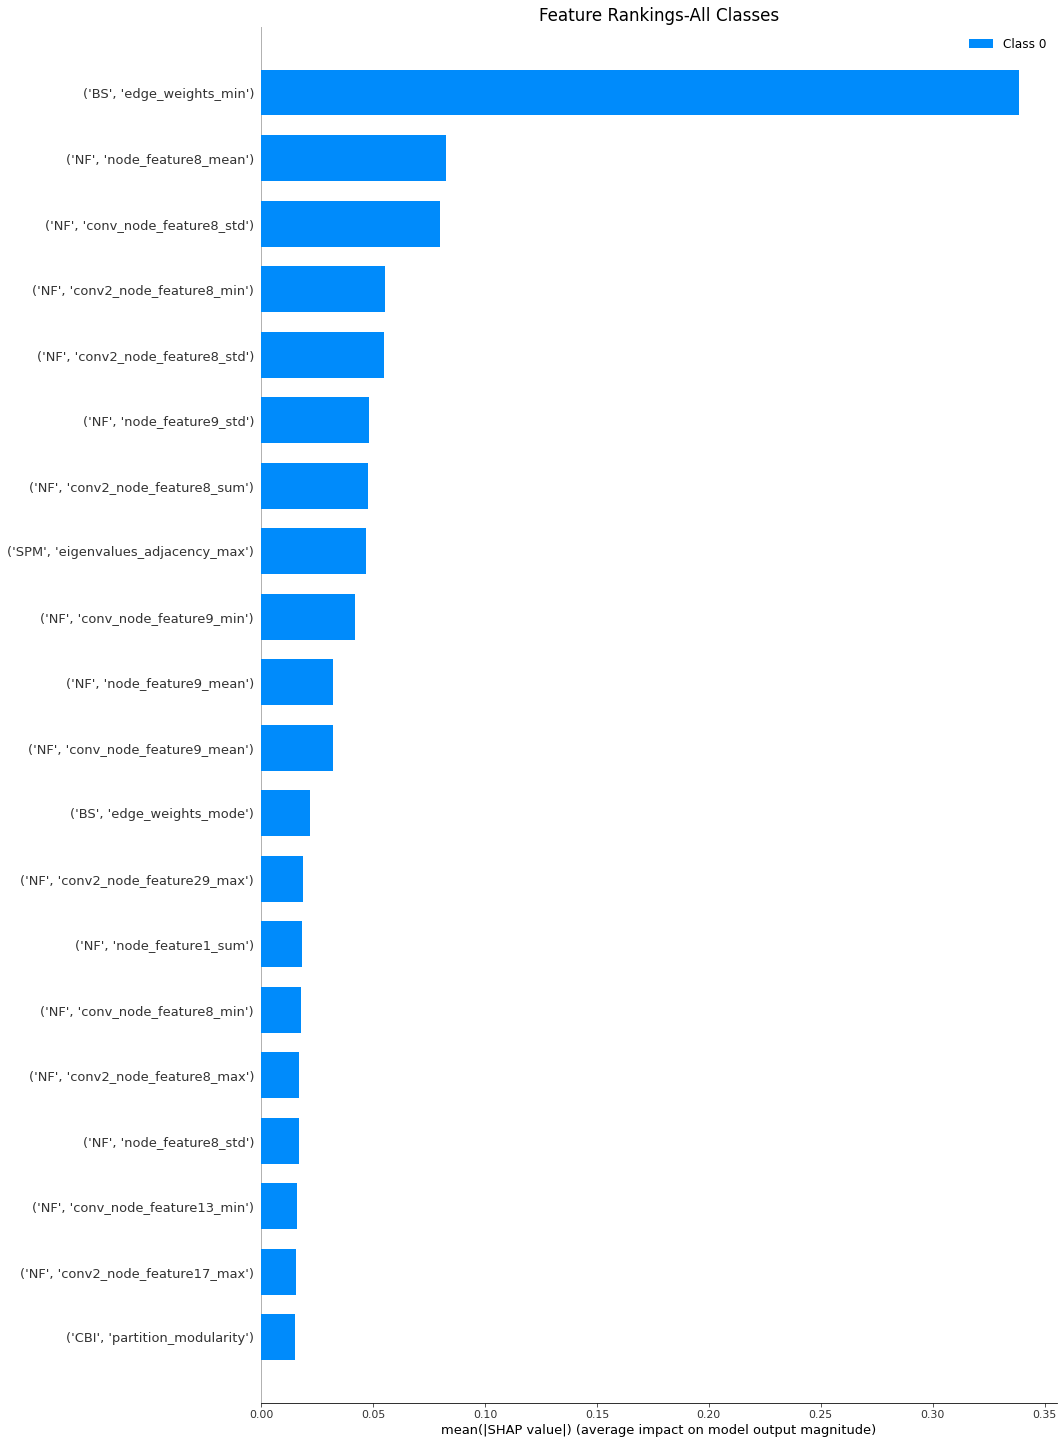

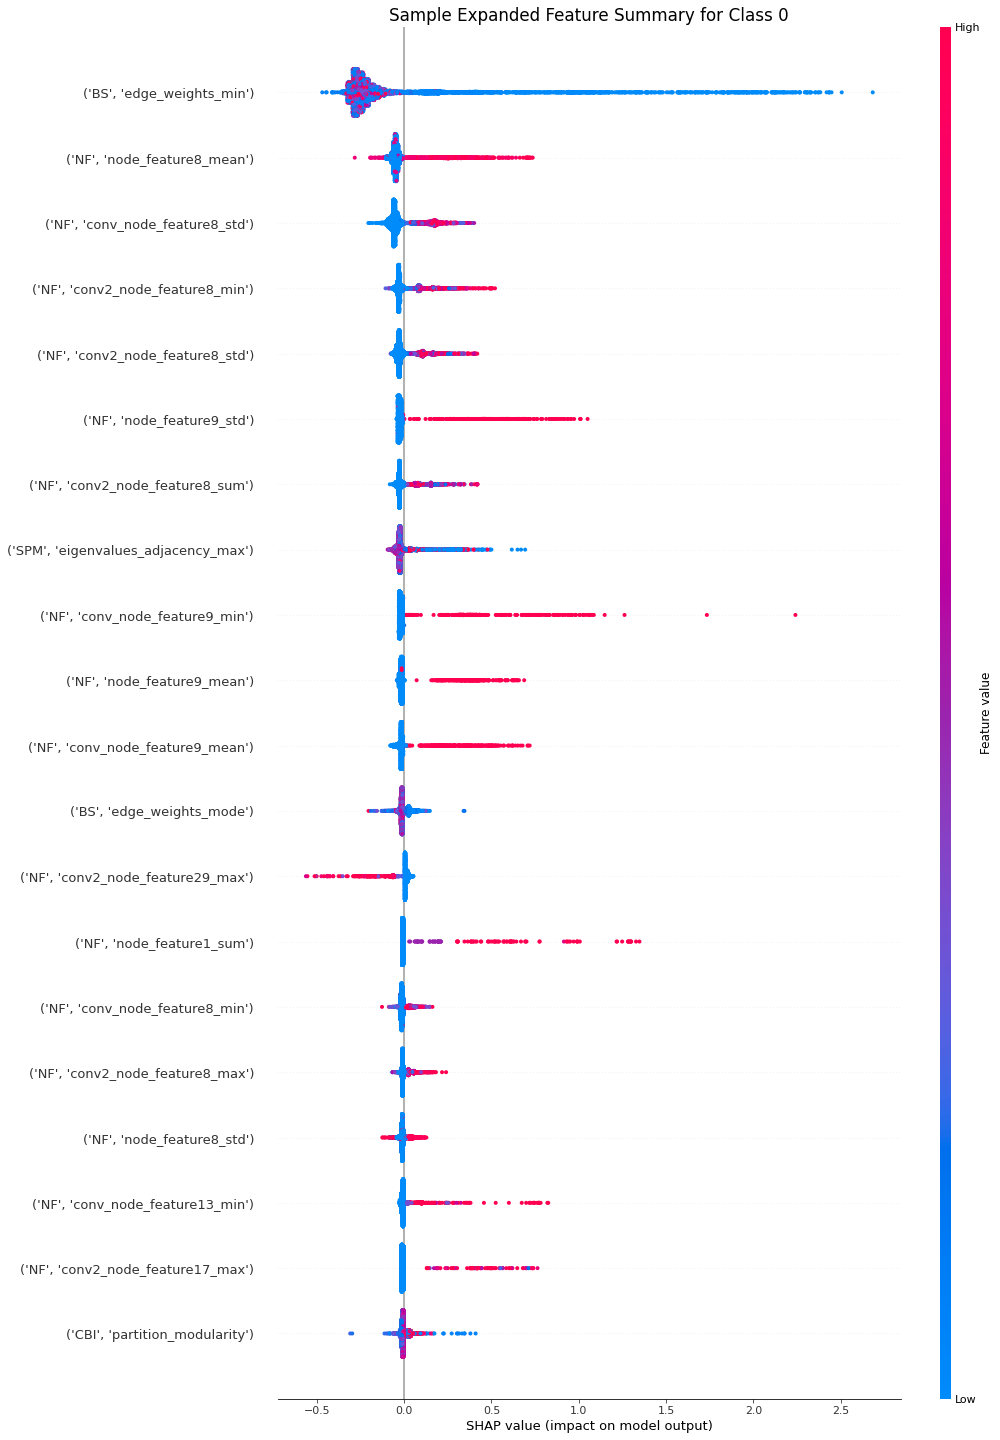

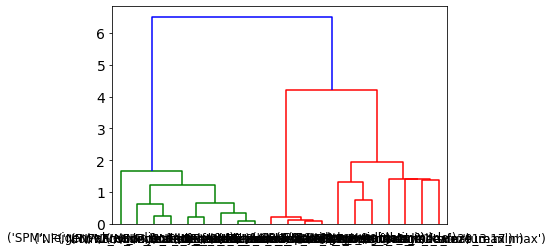

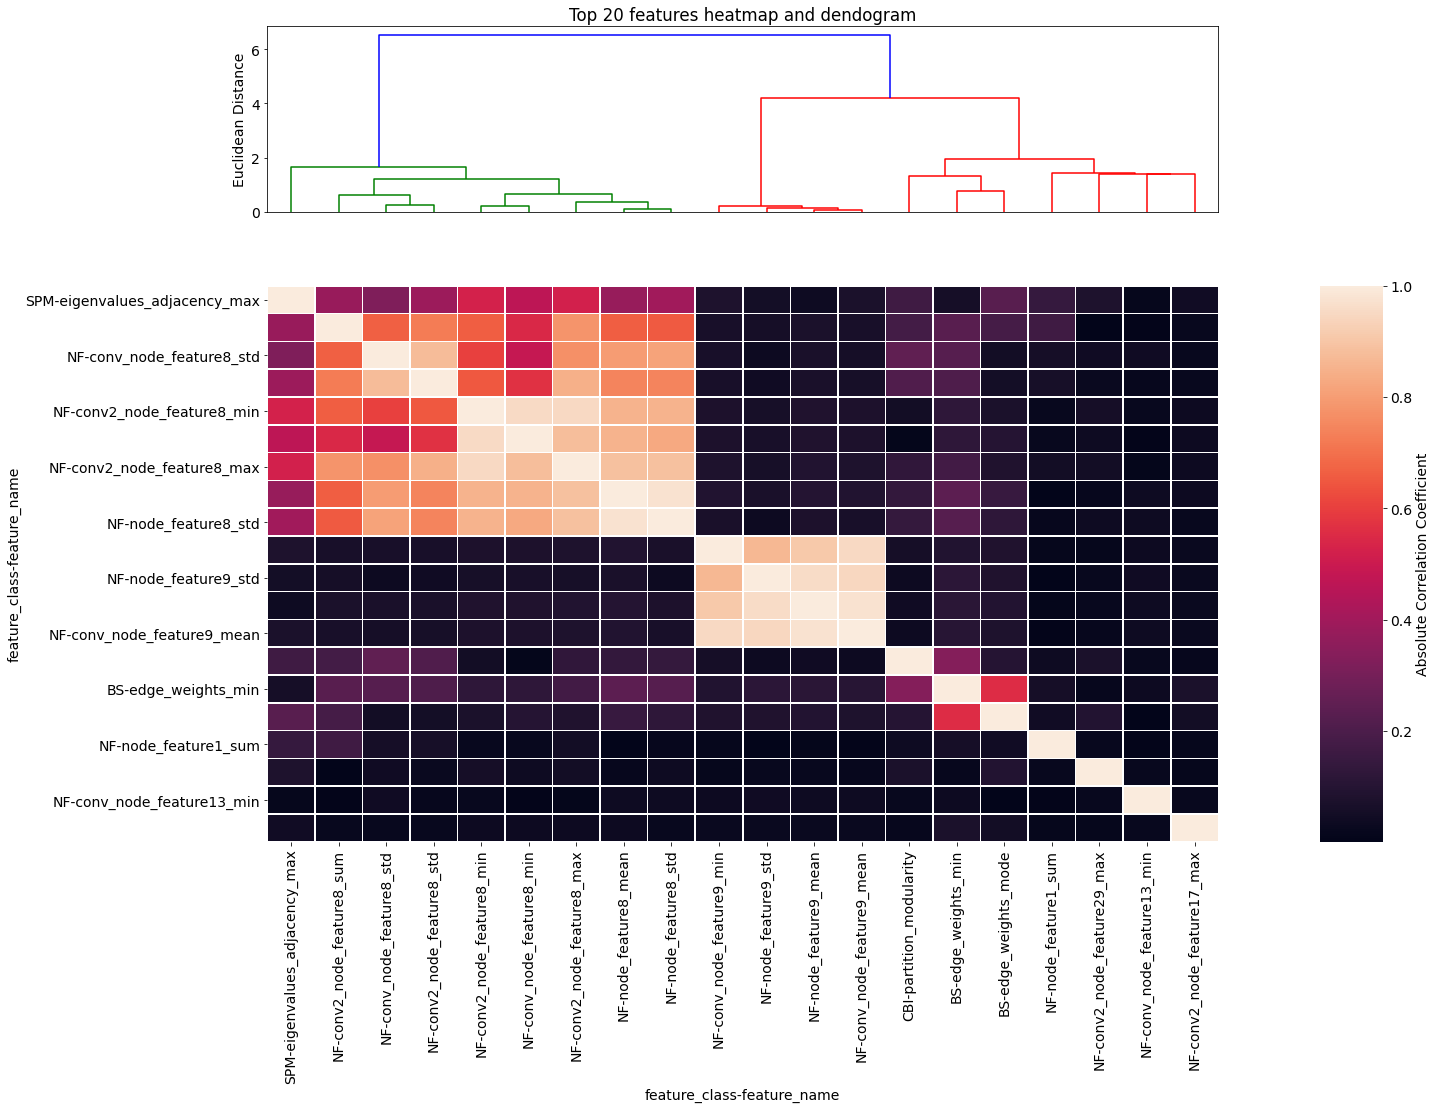

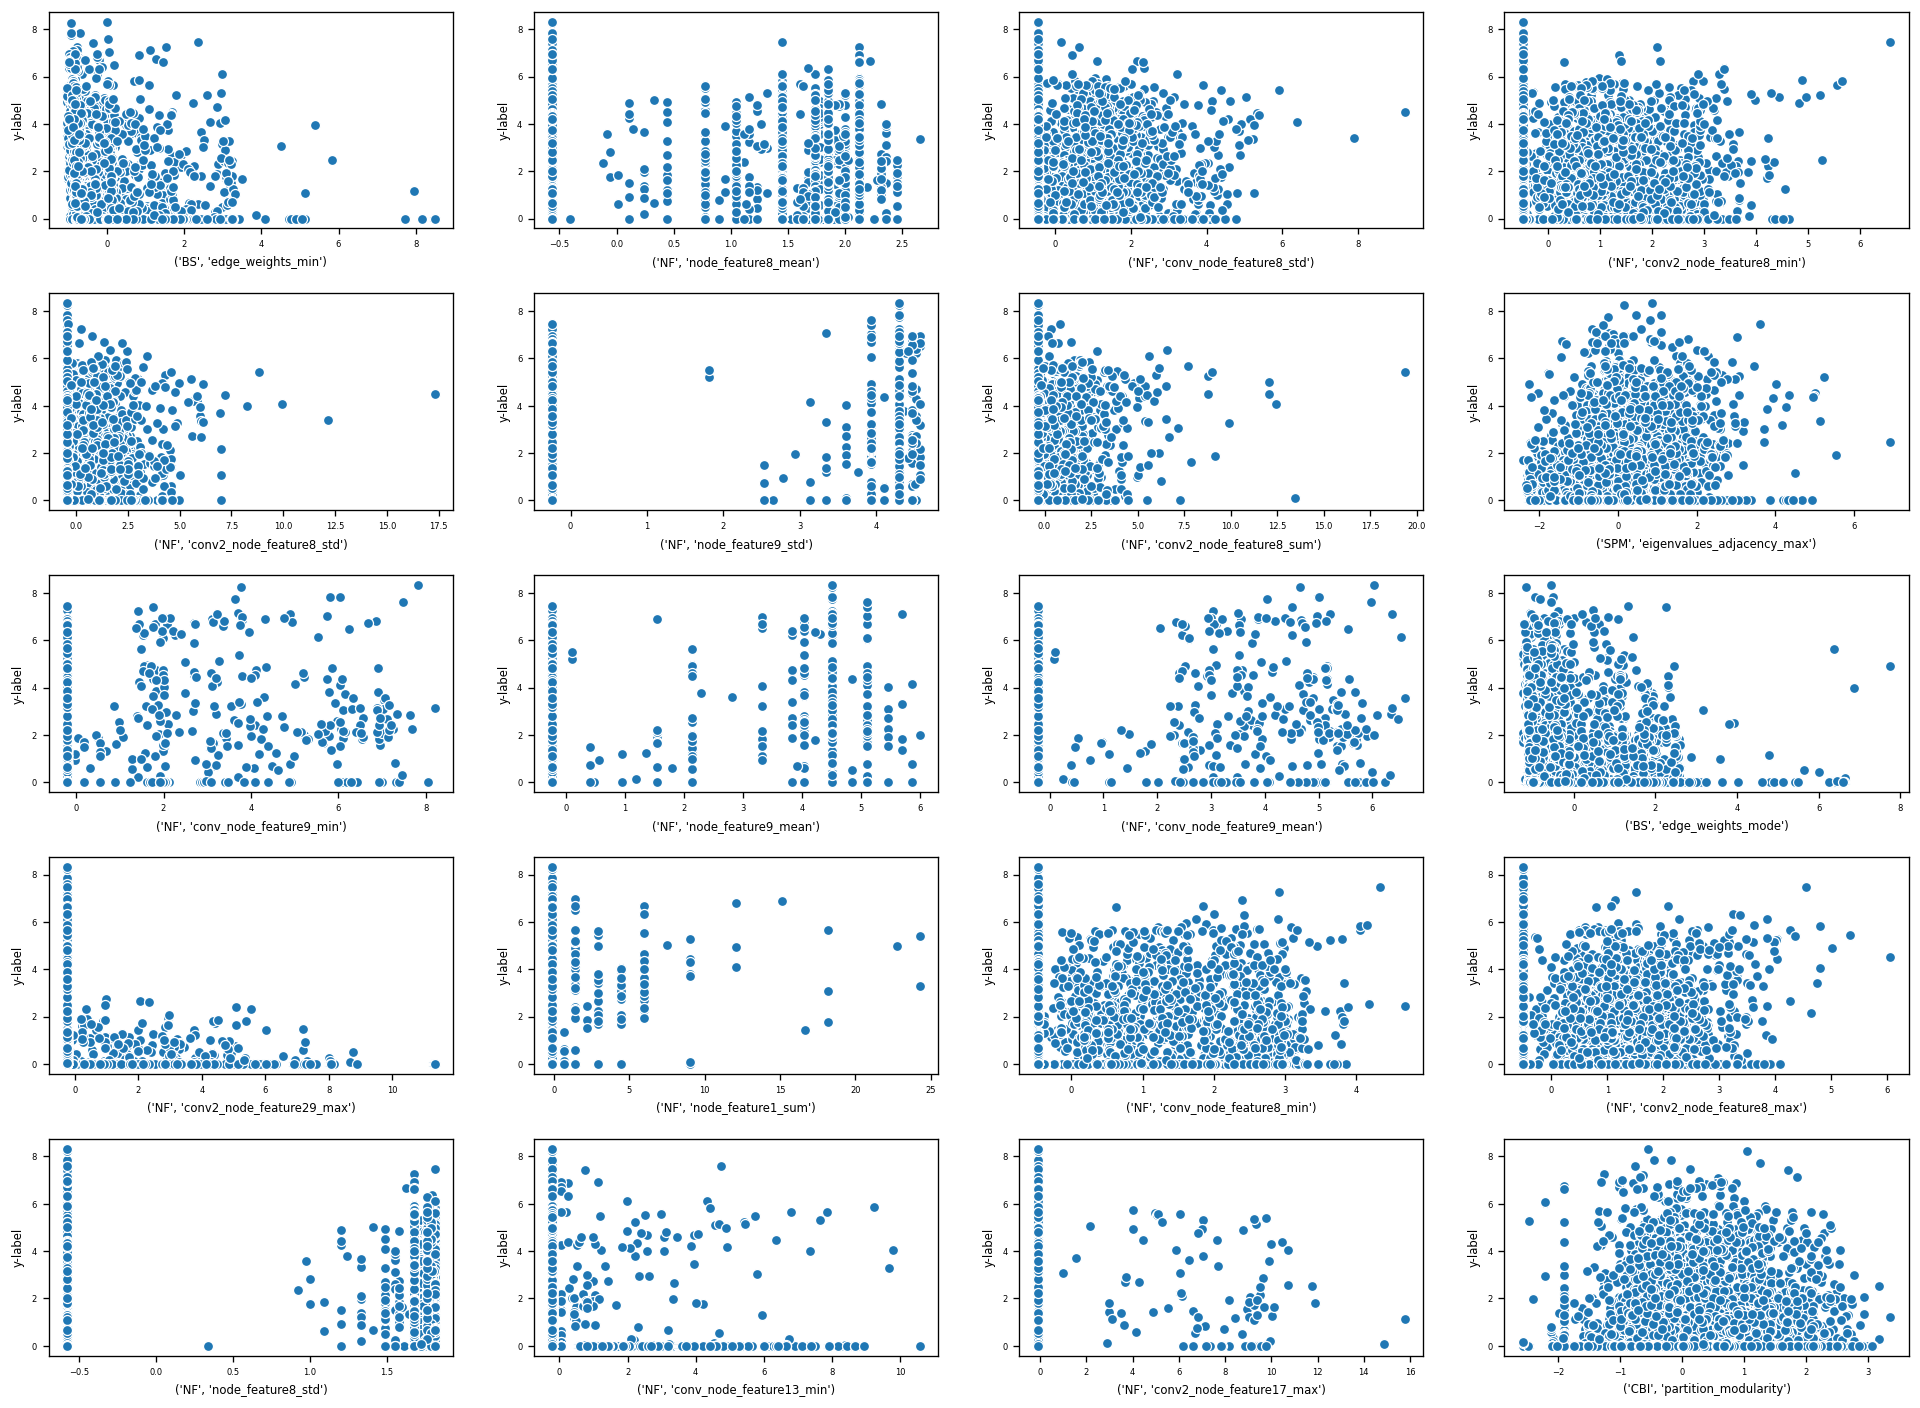

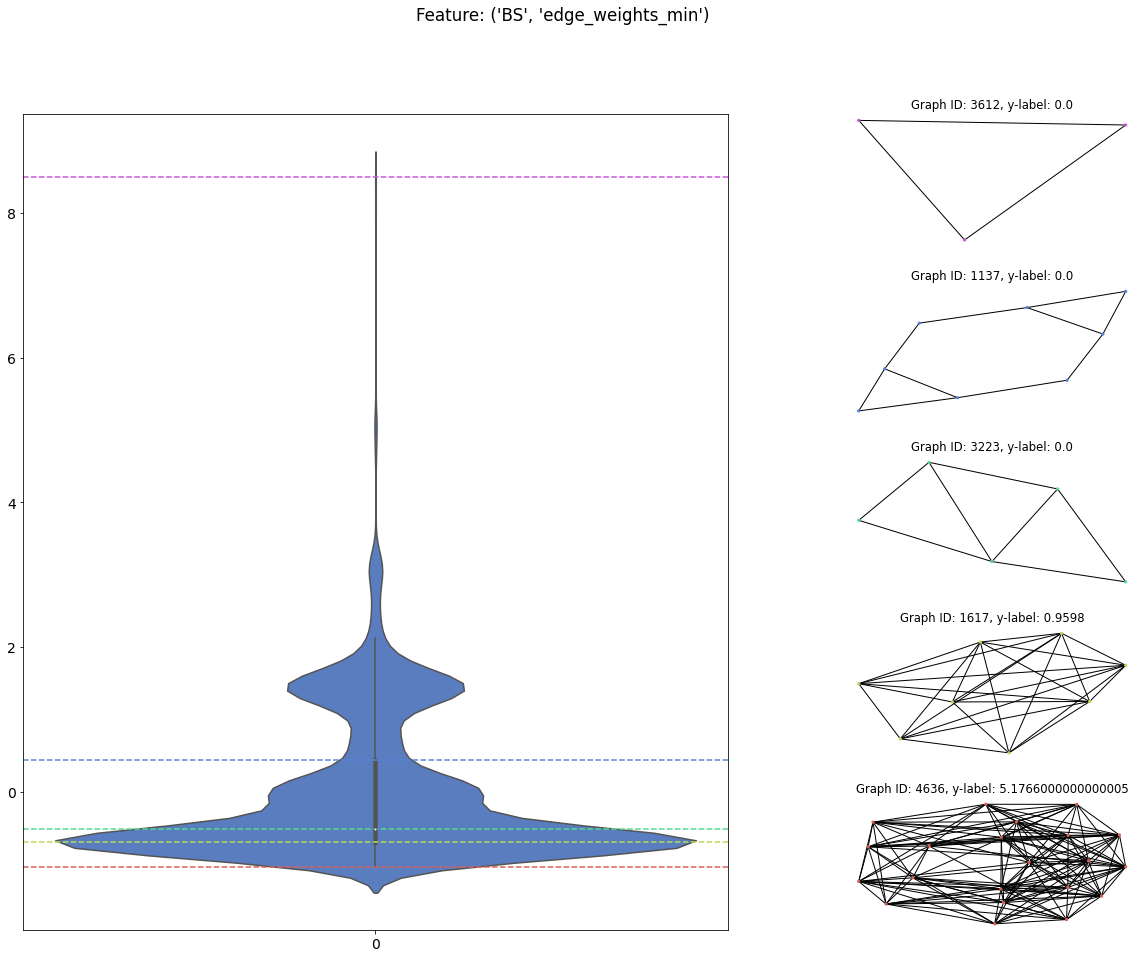

In [22]:
# implement a regression analyse of the features
h.analyse_features(feature_file='./results/molecules/all_features.pkl',
                   results_folder='./results/molecules')

